# Quadratic RF Spoiling bSSFP #

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit

In [2]:
# FUNCTIONS
#RF pulse excitation matrix
def RF_pulse(alpha, phi):
    #The RF pulse tip the spin "alpha" degree from z axis
    #and a phase shift of "phi" degree clockwise from x axis
    
    #convert in to radians 
    a = math.radians(alpha)
    p = math.radians(phi)
    #each term of the matrix
    r11 = math.cos(a)*math.sin(p)**2 + math.cos(p)**2
    r12 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r13 = - math.sin(a)*math.sin(p)
    r21 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r22 = math.cos(a)*math.cos(p)**2 + math.sin(p)**2
    r23 = math.sin(a)*math.cos(p)
    r31 = math.sin(a)*math.sin(p)
    r32 = - math.sin(a)*math.cos(p)
    r33 = math.cos(a)
    R = np.asarray([[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]], dtype = float)
    
    return R

#T1 recovery, T2 decay terms effect for time t
def Relaxation(t, T1, T2):
    e2 = np.exp(-t/T2)
    e1 = np.exp(-t/T1)
    E = np.asarray([[e2 , 0, 0],[0, e2, 0],[0, 0, e1]], dtype = float)
    
    return E

#Precession term effect on off-resonance (f_off Hz) spin at time t
def Precession(f_off, t):
    #free-precession angle beta
    b = f_off*t*2*math.pi
    #rad
    #b = math.radians(beta)
    P = np.asarray([[math.cos(b), math.sin(b), 0],[-math.sin(b), math.cos(b), 0],[0, 0, 1]], dtype = float)
    
    return P

#Calculate the phase shift for current TR (quadratic spoiling)
def QuadraticPhase(N, n):
    n = n%N
    phi_quad = 360/N
    phase = phi_quad*n*n/2
 
    #in degree
    return phase


    

<p>Parameters T1, T2, TR, TE, tip angle, period, initial magnetisation. <p/>
<p>phase $\phi_n =\frac{n^2 \times \phi_{quad}}{2} $ <p/>

In [3]:
# the parameters used in this simulation 
#time unit --- second
proton_density = 1.0
T1 = 900e-3
T2 = 44e-3
TR = 2.5e-3 
TE = TR/2
# tip angle alpha 10, 30, 90 degree
tip_angle = [10]
#phase cycling
Period = 2
#initial magnetisation 
M0 = np.asarray([[0],[0],[1]],dtype = float)



# data simulation #
<p> draw off-resonance profile and F states <p\>

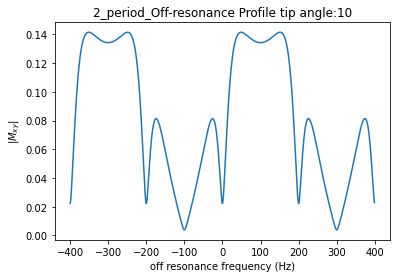

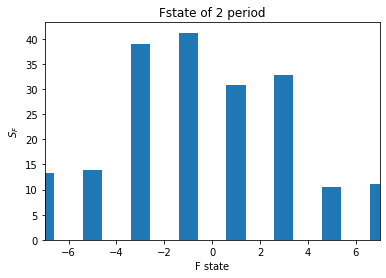

In [4]:

#----------------------------------------------------------------------------------------------
#repeated period in the off-resonance profile
off_res_max = 400
Rep_num = off_res_max*2/(1/TR)

for a in tip_angle:
    
    #store value
    off_resonance_f = np.asarray([], dtype = int)
    M_complex_steady = np.asarray([], dtype = float)
    M_complex_steady_2 = np.asarray([], dtype = float)
    M_complex_steady_3 = np.asarray([], dtype = float)
    M_complex_steady_4 = np.asarray([], dtype = float)

    #Find steady state value for different off-resonance 
    #f_off = 200 is next period, so here we only use -200~199
    for f_off in range(-off_res_max,off_res_max,1):
        M_pre = M0 #initial pre pulse magnetisation 
        #templorary store value
        M_complex = np.asarray([], dtype = float)
        phase_shift = 0
        Period_num = 0

        #repeat 1000 times for each off-resonance frequency
        for k in range(1,1000):
            #Calculate phase shift (degree) for this TR
            phase_shift = QuadraticPhase(Period, Period_num)
            #Tip
            M_post = RF_pulse(a,phase_shift) @ M_pre
            
            #Consider T1 recovery, T2 decay and precession
            #@ time TE 
            P_TE = Precession(f_off,TE) #precession matrix at t = TE
            E_TE = Relaxation(TE, T1, T2) #Relaxation matrix at t = TE

            M_TE = P_TE @ E_TE @ M_post + (np.identity(3) - E_TE) @ M0 #magnetisation at TE
            #M_transverse = np.sqrt(M_TE[0]**2+M_TE[1]**2)

            #@ time TR 
            P_TR = Precession(f_off,TR) #precession matrix at t = TR
            E_TR = Relaxation(TR, T1, T2) #Relaxation matrix at t = TR
            M_TR = P_TR @ E_TR @ M_post + (np.identity(3) - E_TR) @ M0 #magnetisation at TR
            M_pre = M_TR
            
            #store the transverse magnetisation in complex form, Mx+iMy
            M_complex = np.append(M_complex, complex(M_TE[0],M_TE[1]))
           
            Period_num = Period_num + 1
            
            
        #END
        #take the final steady signal, store the transverse steady state signal for different off-resonance frequency
        M_complex_steady = np.append(M_complex_steady, M_complex[-1])
        M_complex_steady_2 = np.append(M_complex_steady_2, M_complex[-2])
        M_complex_steady_3 = np.append(M_complex_steady_3, M_complex[-3])
        M_complex_steady_4 = np.append(M_complex_steady_4, M_complex[-4])
        off_resonance_f = np.append(off_resonance_f, f_off)
        
        
    #END
    #Fourier transform of the off-resonance profile --> contribution from each F-state
    S_F = np.fft.fft(M_complex_steady)
    S_F = np.absolute(S_F)
    S_F = np.fft.fftshift(S_F)
   
    F_state = np.fft.fftfreq(M_complex_steady.shape[-1], d = 1.0)
    F_state = np.fft.fftshift(F_state)*M_complex_steady.shape[-1]
  

    
    
    #plot M_xy at steady state against off-resonance frequency
    plt.figure(1)
    plt.plot(off_resonance_f, np.absolute(M_complex_steady))
    plt.xlabel("off resonance frequency (Hz)")
    plt.ylabel("$|M_{xy}|$")
    plt.title(str(Period)+"_period_Off-resonance Profile tip angle:" + str(a))
    #plt.savefig(".\Figure\OffresProfile_" + str(Period)+"_period"+str(tip_angle)+".jpg")
 
    
   
   
    plt.figure(2)
    plt.xlim([-7,7])
    plt.bar(F_state, S_F)
    plt.xlabel("F state")
    plt.ylabel("$S_F$")
    plt.title("Fstate of " + str(Period)+ " period")
    #save figure
    #plt.savefig(".\Figure\Fstate_" + str(Period)+"_period"+str(tip_angle)+".jpg")
    
   

Text(0.5, 1.0, 'Fstate of 2 period')

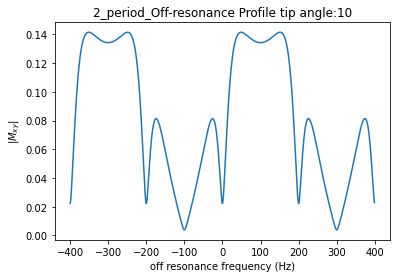

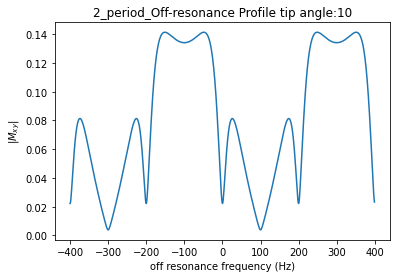

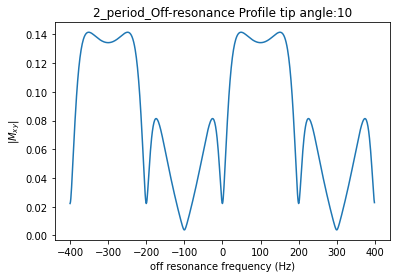

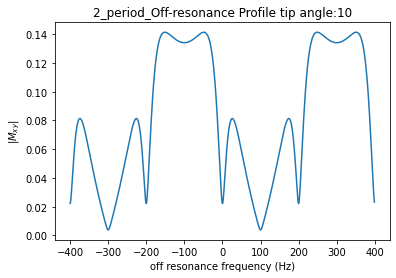

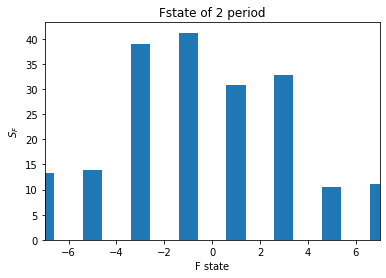

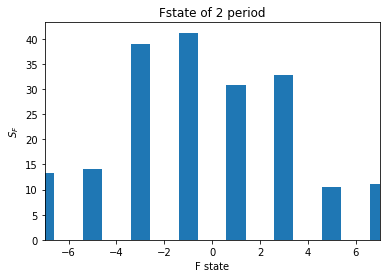

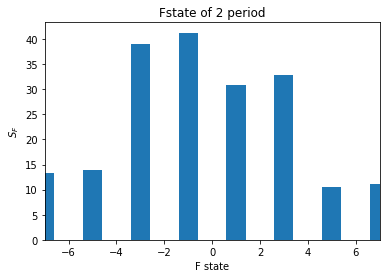

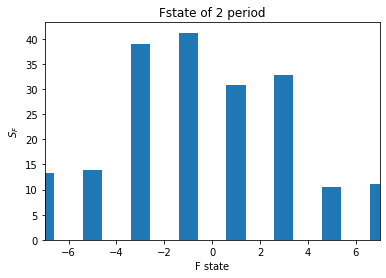

In [16]:
 #plot M_xy at steady state against off-resonance frequency
plt.figure(1)
plt.plot(off_resonance_f, np.absolute(M_complex_steady))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title(str(Period)+"_period_Off-resonance Profile tip angle:" + str(a))

    #plot M_xy at steady state against off-resonance frequency
plt.figure(2)
plt.plot(off_resonance_f, np.absolute(M_complex_steady_2))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title(str(Period)+"_period_Off-resonance Profile tip angle:" + str(a))

plt.figure(3)
plt.plot(off_resonance_f, np.absolute(M_complex_steady_3))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title(str(Period)+"_period_Off-resonance Profile tip angle:" + str(a))

plt.figure(4)
plt.plot(off_resonance_f, np.absolute(M_complex_steady_4))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title(str(Period)+"_period_Off-resonance Profile tip angle:" + str(a))

#Fourier transform of the off-resonance profile --> contribution from each F-state
plt.figure(5)
plt.xlim([-7,7])
plt.bar(F_state, S_F)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.title("Fstate of " + str(Period)+ " period")

plt.figure(6)
S_F_2 = np.fft.fft(M_complex_steady_2)
S_F_2 = np.absolute(S_F_2)
S_F_2 = np.fft.fftshift(S_F_2)
plt.xlim([-7,7])
plt.bar(F_state, S_F_2)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.title("Fstate of " + str(Period)+ " period")

plt.figure(7)
S_F_3 = np.fft.fft(M_complex_steady_3)
S_F_3 = np.absolute(S_F_3)
S_F_3 = np.fft.fftshift(S_F_3)
plt.xlim([-7,7])
plt.bar(F_state, S_F_3)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.title("Fstate of " + str(Period)+ " period")

plt.figure(8)
S_F_4 = np.fft.fft(M_complex_steady_4)
S_F_4 = np.absolute(S_F_4)
S_F_4 = np.fft.fftshift(S_F_4)
plt.xlim([-7,7])
plt.bar(F_state, S_F_4)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.title("Fstate of " + str(Period)+ " period")

## 

# Measured & Ground Truth T2* calculation #
<p>Calculate T2* ground truth and T2* measured stored in "T2Star_measured" and "T2Star_GT" </p>
<p><b>The Parkinson's Disease T2, T2* coefficient: </b></p>
<p> T1 = 878ms, T2 = 55ms, T2* = 53ms </p>
<p><b>The Healthy Controls T2, T2* coefficient: </b></p>
<p> T1 = 893ms, T2 = 33ms, T2* = 13ms </p>
<p>Using the equation $\frac{1}{T2'} = \frac{1}{T2*}-\frac{1}{T2}$</p>
<p>take average T2 = $\frac{55+33}{2} = 44 ms$ </p>
<p>$\frac{1}{T2'} = \frac{1}{T2*}-\frac{1}{44 ms}$</p>
<p>T2* in range 13 ms to 53 ms when T2' is greater than 0.0185, or smaller than -0.2591 </p>
<p>T2' in range 15 ms to 400 ms </p>

In [151]:
T2Star_GT = np.asarray([], dtype = float)
T2Star_measured = np.asarray([], dtype = float)

for T2_inhom in range (15, 400):
    T2_inhom = T2_inhom*1e-3
    if ((T2_inhom != 0) and (T2_inhom != -T2)):
        
        #-----------------Calculate Ground Truth T2*---------------------------------------------------
        T2Star_GT = np.append(T2Star_GT, 1/((1/T2)+(1/T2_inhom)))

        #-----------------Calculate the T2* from simulation data (measured T2*)------------------------
        #recorded 6 F-states (due to the use of Bloch simulation, these F-states magnitude can only fit a T2 decay curve)
        F_t2 = np.asarray([], dtype = float)
        F_t2_statenum = np.asarray([], dtype = float)
        F_state = np.round(F_state).astype(int) #round F-state all to integer 

        for i in range (0,7):
            F_index = np.where(F_state == float(-1-2*i))

            F_t2_statenum = np.append(F_t2_statenum, i)
            F_t2 = np.append(F_t2, S_F[F_index])
            # print('F-state:'+ str(i) +' S_F:'+ str(S_F[F_index]))

        #transfer F-states (T2 related) to F-states (T2* related)
        F_t2star = np.asarray([], dtype = float)
        time = np.asarray([], dtype = float)
        ## time = TE+F*TR
        time = TE*np.ones(np.shape(F_t2_statenum))+ F_t2_statenum *TR
        F_t2star = F_t2 *np.exp(-time/T2_inhom)

        #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
        #exponential curve fitting to find T2* value
        def func(t, A, R2Star):
            return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
        popt, pcov = curve_fit(func, time, F_t2star)
        T2Star_measured = np.append(T2Star_measured, 1/popt[1])


    #--------------Plots----------------------------------------------------------------------------
#     plt.figure(1)
#     plt.title("F-state magnitude against F-state (T2 decay curve due to Bloch simulation)")
#     plt.bar(F_t2_statenum, F_t2)
#     plt.xlabel("F state")
#     plt.ylabel("$S_F$")

#     plt.figure(2)
#     plt.title("F-state magnitude against time (T2* decay curve)")
#     plt.scatter(time, F_t2star, label = '7 F-state data points')
#     plt.plot(time, func(time, *popt),'r-', label='fit: A=%5.3f, R2*=%5.3f' % tuple(popt))
#     plt.xlabel("time")
#     plt.ylabel("$F-state Magnitude$")
#     plt.legend()

    #print('\nT2* Ground Truth: '+str(T2Star_GT) +'\nT2* Measured: '+ str(T2Star_measured))

Plot measured T2* against ground truth T2*

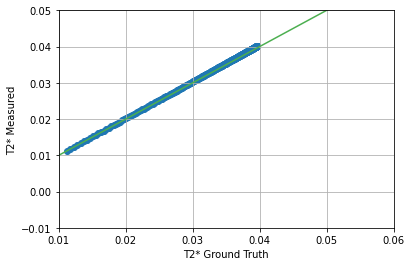

In [152]:
plt.figure
plt.scatter(T2Star_GT, T2Star_measured)
plt.xlabel("T2* Ground Truth")
plt.ylabel("T2* Measured")
x1 = np.array([-2,5])
y1 = np.array([-2,5])
plt.plot(x1,y1,c = '#4CAF50')
plt.xlim(10e-3, 60e-3)
plt.ylim(-10e-3, 50e-3)
plt.grid()
plt.savefig(".\Figure\T2Starvalue_measuredTotruth_" + str(Period)+"_period.jpg")

# Show fitting method 


T2* Ground Truth: 0.012774193548387096
T2* Measured: 0.012847296079296784


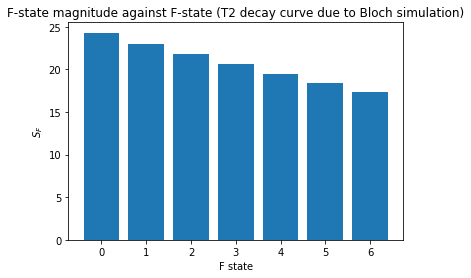

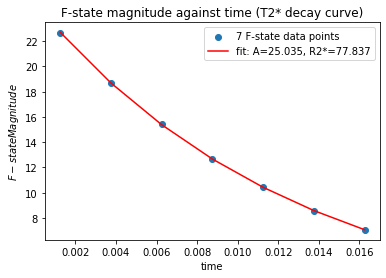

In [153]:
T2_inhom = 18e-3

#-----------------Calculate Ground Truth T2*---------------------------------------------------
T2Star_GT = 1/((1/T2)+(1/T2_inhom))

#-----------------Calculate the T2* from simulation data (measured T2*)------------------------
#recorded 6 F-states (due to the use of Bloch simulation, these F-states magnitude can only fit a T2 decay curve)
F_t2 = np.asarray([], dtype = float)
F_t2_statenum = np.asarray([], dtype = float)
F_state = np.round(F_state).astype(int) #round F-state all to integer 

for i in range (0,7):
    F_index = np.where(F_state == float(-1-2*i))

    F_t2_statenum = np.append(F_t2_statenum, i)
    F_t2 = np.append(F_t2, S_F[F_index])
    # print('F-state:'+ str(i) +' S_F:'+ str(S_F[F_index]))

#transfer F-states (T2 related) to F-states (T2* related)
F_t2star = np.asarray([], dtype = float)
time = np.asarray([], dtype = float)
## time = TE+F*TR
time = TE*np.ones(np.shape(F_t2_statenum))+ F_t2_statenum *TR
F_t2star = F_t2 *np.exp(-time/T2_inhom)

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
#exponential curve fitting to find T2* value
def func(t, A, R2Star):
    return A * np.exp(-R2Star * t)
#fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
popt, pcov = curve_fit(func, time, F_t2star)
T2Star_measured = 1/popt[1]


#--------------Plots----------------------------------------------------------------------------
plt.figure(1)
plt.title("F-state magnitude against F-state (T2 decay curve due to Bloch simulation)")
plt.bar(F_t2_statenum, F_t2)
plt.xlabel("F state")
plt.ylabel("$S_F$")
plt.savefig(".\Figure\FstateOf" + str(Period)+"_period.jpg")

plt.figure(2)
plt.title("F-state magnitude against time (T2* decay curve)")
plt.scatter(time, F_t2star, label = '7 F-state data points')
plt.plot(time, func(time, *popt),'r-', label='fit: A=%5.3f, R2*=%5.3f' % tuple(popt))
plt.xlabel("time")
plt.ylabel("$F-state Magnitude$")
plt.legend()
plt.savefig(".\Figure\T2Starfit" + str(Period)+"_period.jpg")
print('\nT2* Ground Truth: '+str(T2Star_GT) +'\nT2* Measured: '+ str(T2Star_measured))

In [55]:
for i in range (0,24):
    p = QuadraticPhase(12,i)
    print(p)

0.0
15.0
60.0
135.0
240.0
375.0
540.0
735.0
960.0
1215.0
1500.0
1815.0
0.0
15.0
60.0
135.0
240.0
375.0
540.0
735.0
960.0
1215.0
1500.0
1815.0


Text(0, 0.5, '$S_F$')

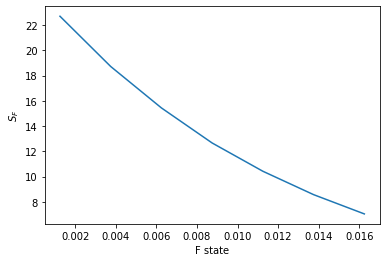

In [61]:
plt.figure
plt.plot(time, F_t2star)
plt.xlabel("F state")
plt.ylabel("$S_F$")

Text(0.5, 1.0, 'Off-resonance Profile tip angle:10')

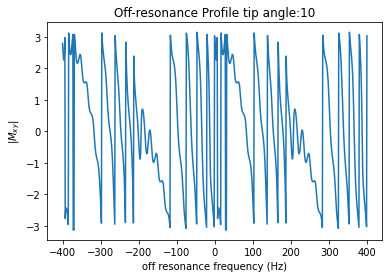

In [ ]:
plt.figure(4)
plt.plot(off_resonance_f, np.angle(M_complex_steady))
plt.xlabel("off resonance frequency (Hz)")
plt.ylabel("$|M_{xy}|$")
plt.title("Off-resonance Profile tip angle:" + str(a))

0.9653493674206295